In [17]:
# Setup

from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

N = 256
D = 9.96
sps = int(40 * N/128)
pupsep = 65/39.3
D_grid = 3.6e-3
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
wf = Wavefront(aperture(pupil_grid))

aberrated = wf.copy()
amplitude = 0.3
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D * spatial_frequency))

In [22]:
# Making an aberration basis. This is in O(N^2) so doubling it quadruples the runtime.

aberration_mode_basis = []
try:
    for i in range(N):
        for j in range(N):
            wf = Wavefront(aperture(pupil_grid))
            wf.electric_field.shape = (N, N)
            l = wf.electric_field.tolist()
            if np.real(l[i][j]) > 0:
                l[i][j] = 0
                wf.electric_field = Field(np.asarray(l).ravel(), wf.grid)
                aberration_mode_basis.append(wf)
    basis_size = len(aberration_mode_basis)
    print(basis_size)
except KeyboardInterrupt:
    print(len(aberration_mode_basis))

51040


In [ ]:
# Propagating to pyramid. (Longest step, about 8-9 minutes, and probably also O(N^2) so 36 minutes for N=256)
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_output_basis = [keck_pyramid.forward(x) for x in aberration_mode_basis]

In [7]:
def get_sub_images(intensity):
    pyramid_grid = make_pupil_grid(N, D_grid)
    images = Field(np.asarray(intensity).ravel(), pyramid_grid)
    pysize = int(np.sqrt(images.size))
    images.shape = (pysize, pysize)

    sub_images = [images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1],
                  images[pysize-sps-1:pysize-1, 0:sps],
                  images[0:sps, 0:sps],
                  images[0:sps, pysize-sps-1:pysize-1]]
    subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

sub_images_basis = [get_sub_images(x.intensity) for x in pyramid_output_basis]

In [8]:
def estimate(EstimatorObject, images_list):
    # Restored the numbering convention to what it was originally because this version of sub_images handles it.
    I_a = images_list[0]
    I_b = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    return [I_x.ravel(), I_y.ravel()]

keck_pyramid_estimator = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
estimated_basis = [estimate(keck_pyramid_estimator, x) for x in sub_images_basis]

In [9]:
# All the above steps, to generate flat wavefront slopes
flat_mode = Wavefront(aperture(pupil_grid))
flat_pyramid_output = keck_pyramid.forward(flat_mode)
flat_x, flat_y = estimate(keck_pyramid_estimator, get_sub_images(flat_pyramid_output.intensity))

In [10]:
estimated_basis = np.asarray([[x - flat_x, y - flat_y] for x, y in estimated_basis])
# In regular Python, write to file here, and read in a separate file. Here, continuing as usual.

In [11]:
M_inv = field_inverse_tikhonov(Field(estimated_basis, make_pupil_grid(sps, D)), 1e-15)
M_inv = M_inv.copy()
M_inv.shape = (basis_size, 2*sps*sps)

In [12]:
# Quickly do all the above without explaining anything
get_pyramid_output = lambda wf: np.asarray(estimate(keck_pyramid_estimator, get_sub_images(keck_pyramid.forward(wf).intensity))).ravel() #should return a (2*sps*sps,) size NumPy Array

In [13]:
# make 
aberrated_images = get_pyramid_output(aberrated)
flat_images = get_pyramid_output(Wavefront(aperture(pupil_grid)))
aberrated_res = aberrated_images - flat_images
reconstructed = M_inv.dot(aberrated_res).tolist()
project_onto = Wavefront(aperture(pupil_grid)).electric_field
project_onto.shape = (N, N)
project_onto = project_onto.tolist()

count, i, j = 0, 0, 0
while count < basis_size:
    if np.real(project_onto[i][j]) > 0:
        project_onto[i][j] = reconstructed[count]
        count += 1
    j += 1
    if j == N - 1:
        j = 0
        i += 1

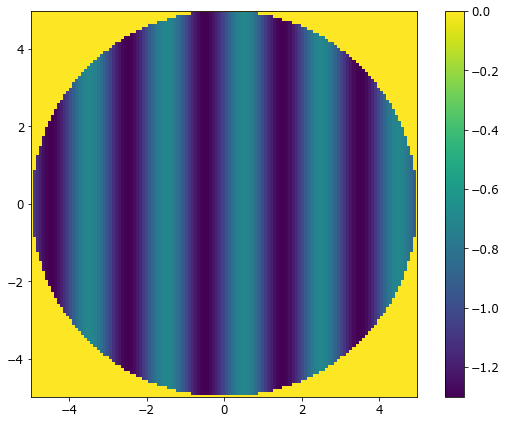

In [14]:
imshow_field(aberrated.phase - Wavefront(aperture(pupil_grid)).intensity, pupil_grid)
plt.colorbar()
plt.show()

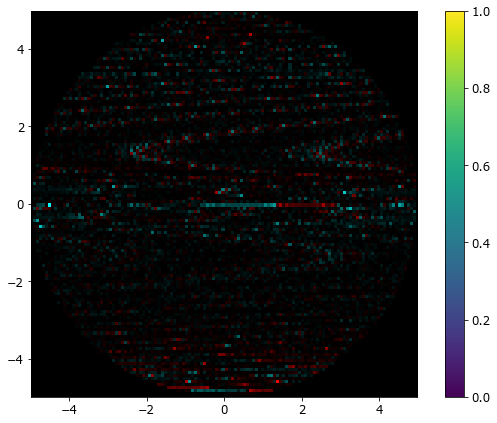

In [15]:
imshow_field(np.asarray(project_onto).ravel() * aperture(pupil_grid), pupil_grid)
plt.colorbar()
plt.show()

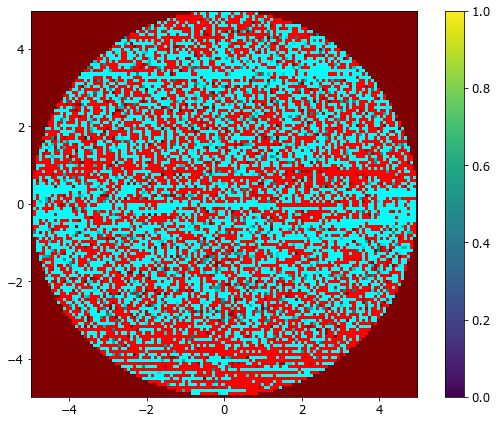

In [16]:
imshow_field(np.asarray(project_onto).ravel() * aperture(pupil_grid), pupil_grid, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()